In [11]:
#Importing necessary Libraries
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc,accuracy_score,f1_score,precision_score,recall_score
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC,Ridge
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.svm import LinearSVC
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import precision_score,recall_score,auc
import xgboost as xgb
import lightgbm as lgb
from mlxtend.regressor import StackingRegressor,StackingCVRegressor

In [12]:
import warnings
warnings.filterwarnings("ignore")

In [13]:
train_data=pd.read_csv('train_values.csv')
test_data=pd.read_csv('test_values.csv')
train_y=pd.read_csv('train_labels.csv')
test_y=pd.read_csv('test_labels.csv')

In [14]:
print('Training data shape:',train_data.shape)
print('Test data shape:',test_data.shape)

Training data shape: (609674, 42)
Test data shape: (152419, 42)


# Data Preparation

In [15]:
# overview of dataset
train_data.head(5)

,building_id,geo1,geo2,geo3,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,242209000291,24,2405,240502,1,0,40,304,7,0,...,0,0,0,0,0,0,0,0,0,0
1,248707000181,24,2412,241205,2,2,26,640,20,20,...,0,0,0,0,0,0,0,0,0,0
2,236801000081,23,2303,230302,2,0,20,300,15,0,...,0,0,0,0,0,0,0,0,0,0
3,242308000591,24,2405,240505,3,3,9,864,30,30,...,0,0,0,0,0,0,0,0,0,0
4,290905010091,29,2903,290302,2,2,24,400,18,18,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# features
train_data.columns

Index(['building_id', 'geo1', 'geo2', 'geo3', 'count_floors_pre_eq',
       'count_floors_post_eq', 'age_building', 'plinth_area_sq_ft',
       'height_ft_pre_eq', 'height_ft_post_eq', 'land_surface_condition',
       'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type',
       'position', 'plan_configuration', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'damage_grade', 'legal_ownership_status', 'count_families',
       'has_secondary_use', 'has_secondary_use_agriculture',
       'has_secondary_use_hotel', 'has_secondary_use_rental',
       'has_secondary_use_institution', 'has_se

In [17]:
#Checking for missing values
print('We have {} NaN/Null values in train'.format(train_data.isnull().values.sum()))
print('We have {} NaN/Null values in test'.format(test_data.isnull().values.sum()))

We have 0 NaN/Null values in train
We have 0 NaN/Null values in test


In [19]:
train_data.damage_grade=train_data.damage_grade.replace({1:'Low',2:'Medium',3:'High'})
test_data.damage_grade=test_data.damage_grade.replace({1:'Low',2:'Medium',3:'High'})

# Check For Imbalance

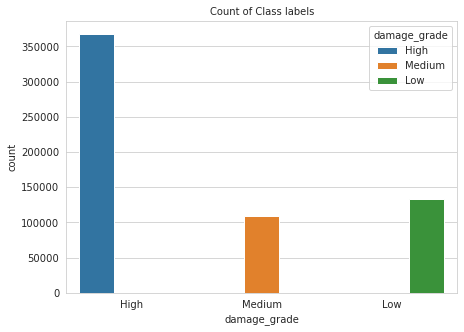

In [20]:
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Dejavu Sans'
plt.figure(figsize=(7,5))
plt.title('Count of Class labels', fontsize=10)
sns.countplot(x='damage_grade',data=train_data,hue='damage_grade')
plt.show()

In [21]:
print('Number of properties with low damage:{0:.2f}%'.format((len(train_data[train_data['damage_grade']=='Low'])/len(train_data))*100))
print('Number of properties with medium damage:{0:.2f}%'.format((len(train_data[train_data['damage_grade']=='Medium'])/len(train_data))*100))
print('Number of properties with high damage:{0:.2f}%'.format((len(train_data[train_data['damage_grade']=='High'])/len(train_data))*100))

Number of properties with low damage:21.79%
Number of properties with medium damage:17.90%
Number of properties with high damage:60.31%


# checking for correlation

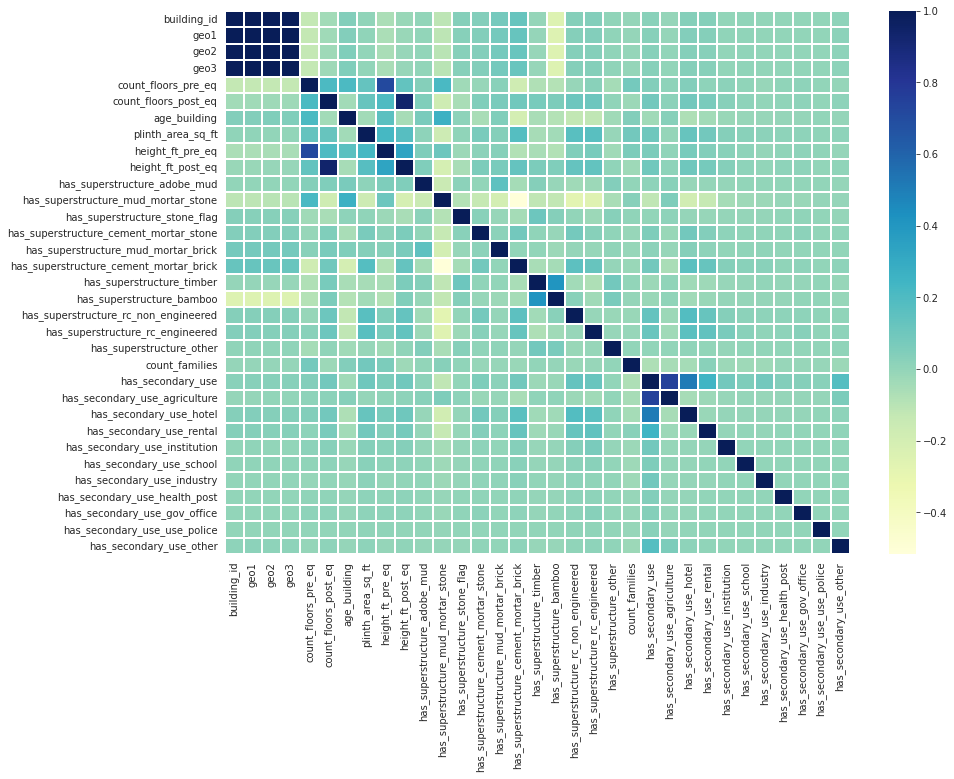

In [23]:
corrmat=train_data.corr(method='spearman')
f,ax=plt.subplots(figsize=(14,10))
sns.heatmap(corrmat,ax=ax,cmap="YlGnBu", linewidths=0.1);

# Age Feature analysis

In [25]:
train_data.age_building.describe()

count    609674.000000
mean         24.307195
std          65.013995
min           0.000000
25%           9.000000
50%          16.000000
75%          27.000000
max         999.000000
Name: age_building, dtype: float64

<AxesSubplot:title={'center':'Damage snapshot properties with less than 10 years old'}, xlabel='age_building', ylabel='count'>

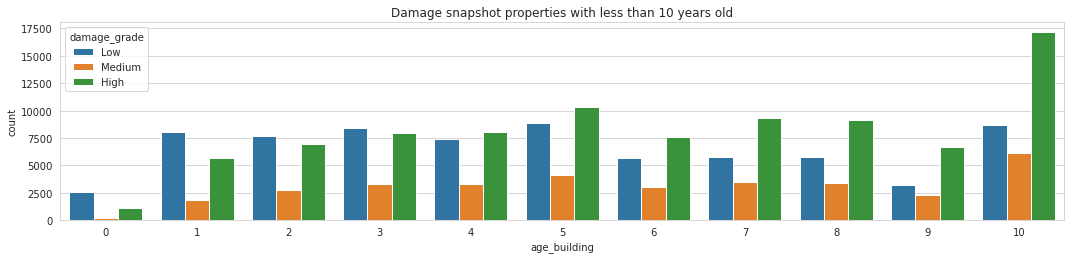

In [27]:
plt.figure(figsize=(18,8))
plt.subplot(211)
plt.title('Damage snapshot properties with less than 10 years old')
tr=train_data[train_data['age_building']<=10]
sns.countplot(x='age_building',data=tr,hue='damage_grade')

<AxesSubplot:title={'center':'Damage snapshot properties with less than 30 years old'}, xlabel='age_building', ylabel='count'>

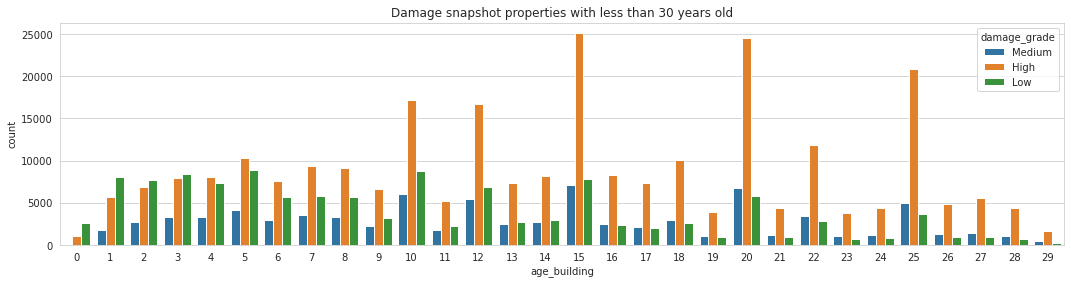

In [28]:
plt.figure(figsize=(18,9))
plt.subplot(211)
plt.title('Damage snapshot properties with less than 30 years old')
tr=train_data[train_data['age_building']<30]
sns.countplot(x='age_building',data=tr,hue='damage_grade')

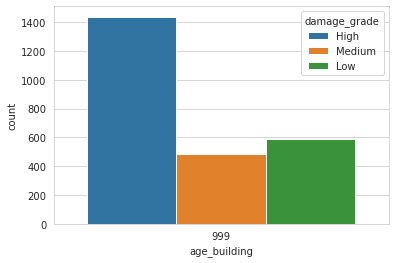

In [30]:
train_950=train_data[train_data.age_building>950]
sns.countplot(x='age_building',data=train_950,hue='damage_grade');

# has superstructure adobe mud feature analysis

<AxesSubplot:title={'center':'Damage analysis of properties built over mud'}, xlabel='has_superstructure_adobe_mud', ylabel='count'>

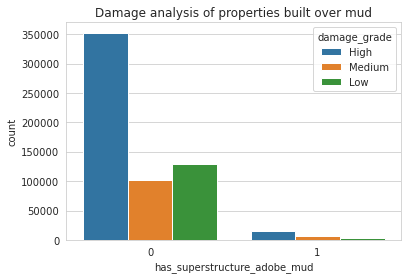

In [32]:
plt.title('Damage analysis of properties built over mud')
sns.countplot(x='has_superstructure_adobe_mud',data=train_data,hue='damage_grade')

In [33]:
tr_no=train_data[train_data['has_superstructure_adobe_mud']==0]
tr_yes=train_data[train_data['has_superstructure_adobe_mud']==1]
print('------------Damage snapshot of properties not built over mud----------------')
print()
print('Number of properties with low damage:{0:.2f}%'.format((len(tr_no[tr_no['damage_grade']=='Low'])/len(tr_no))*100))
print('Number of properties with medium damage:{0:.2f}%'.format((len(tr_no[tr_no['damage_grade']=='Medium'])/len(tr_no))*100))
print('Number of properties with high damage:{0:.2f}%'.format((len(tr_no[tr_no['damage_grade']=='High'])/len(tr_no))*100))
print()
print('------------Damage snapshot of properties  built over mud----------------')
print()
print('Number of properties with low damage:{0:.2f}%'.format((len(tr_yes[tr_yes['damage_grade']=='Low'])/len(tr_yes))*100))
print('Number of properties with mdium damage:{0:.2f}%'.format((len(tr_yes[tr_yes['damage_grade']=='Medium'])/len(tr_yes))*100))
print('Number of properties with high damage:{0:.2f}%'.format((len(tr_yes[tr_yes['damage_grade']=='High'])/len(tr_yes))*100))

------------Damage snapshot of properties not built over mud----------------

Number of properties with low damage:22.06%
Number of properties with medium damage:17.59%
Number of properties with high damage:60.35%

------------Damage snapshot of properties  built over mud----------------

Number of properties with low damage:15.75%
Number of properties with mdium damage:24.85%
Number of properties with high damage:59.40%


# Roof type feature analysis

<AxesSubplot:title={'center':'Damage analysis over roof_type'}, xlabel='roof_type', ylabel='count'>

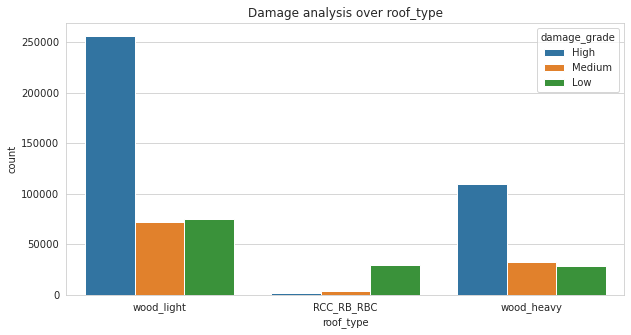

In [34]:
plt.figure(figsize=(10,5))
plt.title('Damage analysis over roof_type')
sns.countplot(x='roof_type',data=train_data,hue='damage_grade')

In [35]:
tr_n=train_data[train_data['roof_type']=='wood_light']
tr_q=train_data[train_data['roof_type']=='wood_heavy']
tr_x=train_data[train_data['roof_type']=='RCC_RB_RBC']
print('------------Damage snapshot of properties with roof type wood_light----------------')
print()
print('Number of properties with low damage:{0:.2f}%'.format((len(tr_n[tr_n['damage_grade']=='Low'])/len(tr_n))*100))
print('Number of properties with medium damage:{0:.2f}%'.format((len(tr_n[tr_n['damage_grade']=='Medium'])/len(tr_n))*100))
print('Number of properties with high damage:{0:.2f}%'.format((len(tr_n[tr_n['damage_grade']=='High'])/len(tr_n))*100))
print()
print('------------Damage snapshot of properties with roof type wood_heavy----------------')
print()
print('Number of properties with low damage:{0:.2f}%'.format((len(tr_q[tr_q['damage_grade']=='Low'])/len(tr_q))*100))
print('Number of properties with medium damage:{0:.2f}%'.format((len(tr_q[tr_q['damage_grade']=='Medium'])/len(tr_q))*100))
print('Number of properties with high damage:{0:.2f}%'.format((len(tr_q[tr_q['damage_grade']=='High'])/len(tr_q))*100))
print()
print('------------Damage snapshot of properties with roof type RCC_RB_RBC ----------------')
print()
print('Number of properties with low damage:{0:.2f}%'.format((len(tr_x[tr_x['damage_grade']=='Low'])/len(tr_x))*100))
print('Number of properties with medium damage:{0:.2f}%'.format((len(tr_x[tr_x['damage_grade']=='Medium'])/len(tr_x))*100))
print('Number of properties with high damage:{0:.2f}%'.format((len(tr_x[tr_x['damage_grade']=='High'])/len(tr_x))*100))
print()

------------Damage snapshot of properties with roof type wood_light----------------

Number of properties with low damage:18.56%
Number of properties with medium damage:17.84%
Number of properties with high damage:63.60%

------------Damage snapshot of properties with roof type wood_heavy----------------

Number of properties with low damage:16.80%
Number of properties with medium damage:19.31%
Number of properties with high damage:63.89%

------------Damage snapshot of properties with roof type RCC_RB_RBC ----------------

Number of properties with low damage:82.31%
Number of properties with medium damage:11.84%
Number of properties with high damage:5.84%

